# Сверточная нейросеть для распознавания рукописных цифр из датасета MNIST.

In [1]:
import numpy as np
from abc import ABC, abstractmethod
from typing import List

class Module(ABC):
    def __init__(self):
        self.output = None
        self.training = True

    # Функция вычисления выхода слоя
    @abstractmethod
    def compute_output(self, input, *args, **kwargs) -> np.array:
        raise NotImplementedError

    # Функция вычисления градиента входа
    @abstractmethod
    def compute_grad_input(self, input, *args, **kwargs) -> np.array:
        raise NotImplementedError

    # Метод обновления градиентов параметров модуля
    def update_grad_parameters(self, input, *args, **kwargs):
        pass

    # Возможность вызвать модуль (вызывает forward у модуля)
    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    # Выыполняет прямое распространение, использует compute_output
    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    # Выполняет обратное распространение с обновлением параметров
    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    # Режимы модели (обучение и предсказание на тестах)
    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    # Зануление градиентов
    def zero_grad(self):
        pass

    # Возвращает параметры
    def parameters(self) -> List[np.array]:
        return []

    # Возвращает градиенты
    def parameters_grad(self) -> List[np.array]:
        return []

    # Строковое представление класса
    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Criterion(ABC):
    def __init__(self):
        self.output = None

    @abstractmethod
    def compute_output(self, input: np.array, target: np.array) -> float:
        raise NotImplementedError

    @abstractmethod
    def compute_grad_input(self, input: np.array, target: np.array) -> np.array:
        raise NotImplementedError

    def __call__(self, input: np.array, target: np.array) -> float:
        return self.forward(input, target)

    def forward(self, input: np.array, target: np.array) -> float:
        self.output = self.compute_output(input, target)
        return self.output

    def backward(self, input: np.array, target: np.array) -> np.array:
        grad_input = self.compute_grad_input(input, target)
        return grad_input

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Optimizer(ABC):
    # Создание оптимизатора с заданным модулем и состоянием
    def __init__(self, module: Module):
        self.module = module
        self.state = {}

    def zero_grad(self):
        self.module.zero_grad()

    # Абстрактный метод для обновления параметров модуля
    @abstractmethod
    def step(self):
        raise NotImplementedError

In [2]:
from numpy.core.multiarray import array as array
from scipy.special import expit, softmax, log_softmax

class ReLU(Module):
    def compute_output(self, input: np.array) -> np.array:
        return np.where(input > 0, input, 0)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * np.where(input > 0, 1, 0)

class Tanh(Module):
    def compute_output(self, input: np.array) -> np.array:
        return np.tanh(input)
    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * (1 - (self.compute_output(input) ** 2))

class Sigmoid(Module):
    def compute_output(self, input: np.array) -> np.array:
        return expit(input)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * self.compute_output(input) * (1 - self.compute_output(input))


class Softmax(Module):
    def compute_output(self, input: np.array) -> np.array:
        return softmax(input, axis = 1)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return (grad_output - np.sum(grad_output * self.compute_output(input), axis = 1, keepdims = True)) * self.compute_output(input)


class LogSoftmax(Module):
    def compute_output(self, input: np.array) -> np.array:
        return log_softmax(input, axis = 1)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output - (np.sum(grad_output, axis = 1, keepdims = True) * softmax(input, axis = 1))

In [3]:
from scipy.special import softmax

class CrossEntropyLoss(Criterion):
    def __init__(self):
        super().__init__()
        self.log_softmax = LogSoftmax()

    def compute_output(self, input: np.array, target: np.array) -> float:
        return (-1 / input.shape[0]) * np.sum(input[np.arange(input.shape[0]), target] - np.log(np.sum(np.exp(input), axis = 1)))

    def compute_grad_input(self, input: np.array, target: np.array) -> np.array:
        return (-1 / input.shape[0]) * (np.where(np.arange(input.shape[1]) == target[:, None], 1, 0) - softmax(input, axis = 1))

In [4]:
from typing import Tuple

class SGD(Optimizer):
    def __init__(self, module: Module, lr: float = 1e-3, momentum: float = 0.0,
                 weight_decay: float = 0.0):
        super().__init__(module)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

    def step(self):
        parameters = self.module.parameters()
        gradients = self.module.parameters_grad()
        if 'm' not in self.state:
            self.state['m'] = [np.zeros_like(param) for param in parameters]
        for param, grad, m in zip(parameters, gradients, self.state['m']):
            g = grad + self.weight_decay * param
            np.add(self.momentum * m, g, out = m)
            np.add(param, -self.lr * m, out = param)

In [5]:
from numpy.core.multiarray import array as array

class Linear(Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.random.uniform(-1, 1, (out_features, in_features)) / np.sqrt(in_features)
        self.bias = np.random.uniform(-1, 1, out_features) / np.sqrt(in_features) if bias else None

        self.grad_weight = np.zeros_like(self.weight)
        self.grad_bias = np.zeros_like(self.bias) if bias else None

    def compute_output(self, input: np.array) -> np.array:
        if self.bias is not None:
            return input @ self.weight.T + self.bias
        return input @ self.weight.T

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output @ self.weight

    def update_grad_parameters(self, input: np.array, grad_output: np.array):
        if self.bias is not None:
            self.grad_bias += np.sum(grad_output, axis = 0)
        self.grad_weight += grad_output.T @ input

    def zero_grad(self):
        self.grad_weight.fill(0)
        if self.bias is not None:
            self.grad_bias.fill(0)

    def parameters(self) -> List[np.array]:
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]

    def parameters_grad(self) -> List[np.array]:
        if self.bias is not None:
            return [self.grad_weight, self.grad_bias]
        return [self.grad_weight]

    def __repr__(self) -> str:
        out_features, in_features = self.weight.shape
        return f'Linear(in_features={in_features}, out_features={out_features}, ' \
               f'bias={not self.bias is None})'

class Conv2d(Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, bias: bool = True):
        super().__init__()
        self.weight = np.random.uniform(-1, 1, (out_channels, in_channels, kernel_size, kernel_size)) / np.sqrt(in_channels * kernel_size * kernel_size)
        self.bias = np.random.uniform(-1, 1, out_channels) / np.sqrt(in_channels * kernel_size * kernel_size) if bias else None
        self.grad_weight = np.zeros_like(self.weight)
        self.grad_bias = np.zeros_like(self.bias) if bias else None
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = 1
        self.cache = None

    def getWindows(self, input: np.array, output_size: int, kernel_size: int, padding: int = 0, stride: int = 1, dilate: int = 0):
        working_input = input
        working_pad = padding
        if dilate != 0:
            working_input = np.insert(working_input, range(1, input.shape[2]), 0, axis=2)
            working_input = np.insert(working_input, range(1, input.shape[3]), 0, axis=3)

        if working_pad != 0:
            working_input = np.pad(working_input, pad_width=((0,), (0,), (working_pad,), (working_pad,)), mode='constant', constant_values=(0.,))

        _, _, out_h, out_w = output_size
        out_b, out_c, _, _ = input.shape
        batch_str, channel_str, kern_h_str, kern_w_str = working_input.strides
        return np.lib.stride_tricks.as_strided(
            working_input,
            (out_b, out_c, out_h, out_w, kernel_size, kernel_size),
            (batch_str, channel_str, stride * kern_h_str, stride * kern_w_str, kern_h_str, kern_w_str)
        )

    def compute_output(self, input: np.array) -> np.array:
        n, c, h, w = input.shape
        out_h = (h - self.kernel_size) // self.stride + 1
        out_w = (w - self.kernel_size) // self.stride + 1
        windows = self.getWindows(input, (n, c, out_h, out_w), self.kernel_size, 0, self.stride)
        out = np.einsum('bihwkl,oikl->bohw', windows, self.weight)
        if self.bias is not None:
            out += self.bias[None, :, None, None]
        self.cache = windows
        return out

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        padding = self.kernel_size - 1
        dout_windows = self.getWindows(grad_output, input.shape, self.kernel_size, padding = padding, stride = 1, dilate = self.stride - 1)
        rot_kern = np.rot90(self.weight, 2, axes=(2, 3))
        return np.einsum('bohwkl,oikl->bihw', dout_windows, rot_kern)

    def update_grad_parameters(self, input: np.array, grad_output: np.array):
        windows = self.cache
        self.grad_weight += np.einsum('bihwkl,bohw->oikl', windows, grad_output)
        if self.grad_bias is not None:
            self.grad_bias += np.sum(grad_output, axis = (0, 2, 3))

    def zero_grad(self):
        self.grad_weight.fill(0)
        if self.bias is not None:
            self.grad_bias.fill(0)

    def parameters(self) -> List[np.array]:
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]

    def parameters_grad(self) -> List[np.array]:
        if self.bias is not None:
            return [self.grad_weight, self.grad_bias]
        return [self.grad_weight]

    def __repr__(self) -> str:
        return f'Conv2d(in_channels={self.in_channels}, out_channels={self.out_channels}, kernel_size={self.kernel_size} ' \
               f'bias={not self.bias is None})'

class AvgPool2d(Module):
    def __init__(self, kernel_size : int):
        super().__init__()
        self.kernel_size = kernel_size

    def compute_output(self, input: np.array) -> np.array:
        return input.reshape(input.shape[0], input.shape[1], input.shape[2] // self.kernel_size, self.kernel_size, input.shape[3] // self.kernel_size,
                             self.kernel_size).mean(axis = (3,5))

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        desired_shape = np.repeat(grad_output, 2, axis=2)
        return np.repeat(desired_shape, 2, axis=3) * (1 / (self.kernel_size * self.kernel_size))

    def __repr__(self) -> str:
        return f'AvgPool2d(kernel_size={self.kernel_size})'

class Sequential(Module):
    def __init__(self, *args):
        super().__init__()
        self.modules = list(args)

    def compute_output(self, input: np.array) -> np.array:
        y = input
        for module in self.modules:
            y = module(y)
        return y

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        grad_input = grad_output
        for i in range(len(self.modules) - 1, 0, -1):
            grad_input = self.modules[i].backward(self.modules[i-1].output, grad_input)
        return self.modules[0].backward(input, grad_input)

    def __getitem__(self, item):
        return self.modules[item]

    def train(self):
        for module in self.modules:
            module.train()

    def eval(self):
        for module in self.modules:
            module.eval()

    def zero_grad(self):
        for module in self.modules:
            module.zero_grad()

    def parameters(self) -> List[np.array]:
        return [parameter for module in self.modules for parameter in module.parameters()]

    def parameters_grad(self) -> List[np.array]:
        return [grad for module in self.modules for grad in module.parameters_grad()]

    def __repr__(self) -> str:
        repr_str = 'Sequential(\n'
        for module in self.modules:
            repr_str += ' ' * 4 + repr(module) + '\n'
        repr_str += ')'
        return repr_str


In [6]:
class Lenet(Module):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential(
            Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5),
            ReLU(),
            AvgPool2d(2),
            Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            ReLU(),
            AvgPool2d(2),
            Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5)
        )
        self.head = Sequential(
            Linear(in_features = 120, out_features = 84),
            ReLU(),
            Linear(in_features = 84, out_features = 10),
        )
    def compute_output(self, input: np.array) -> np.array:
        out = self.encoder(input).reshape(input.shape[0], -1)
        return self.head(out)
    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return self.encoder.backward(input,
                                      self.head.backward(self.encoder.output.reshape(input.shape[0], -1), grad_output).reshape(self.encoder.output.shape))
    def train(self):
        self.head.train()
        self.encoder.train()

    def eval(self):
        self.encoder.eval()
        self.head.eval()

    def zero_grad(self):
        self.encoder.zero_grad()
        self.head.zero_grad()

    def parameters(self) -> List[np.array]:
        return self.encoder.parameters() + self.head.parameters()

    def parameters_grad(self) -> List[np.array]:
        return self.encoder.parameters_grad() + self.head.parameters_grad()

In [7]:
model = Lenet()
optimizer = SGD(model, lr = 0.01, momentum = 0.9)
criterion = CrossEntropyLoss()

In [8]:
from torchvision.datasets import MNIST
import torchvision.transforms as T

transform = T.Compose([T.ToTensor(), T.Resize((32, 32))])
train_set = MNIST('.MNIST', transform = transform, train = True, download = True)
test_set = MNIST('.MNIST', transform = transform, train = False, download = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6015704.26it/s]


Extracting .MNIST/MNIST/raw/train-images-idx3-ubyte.gz to .MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 155431.50it/s]


Extracting .MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to .MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1508214.71it/s]


Extracting .MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to .MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3018144.61it/s]


Extracting .MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to .MNIST/MNIST/raw



In [9]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle = False)

In [17]:
from tqdm.notebook import tqdm

num_epochs = 1
pbar_epoch = tqdm(range(1, num_epochs + 1))
pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Train process")

for epoch in pbar_epoch:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()

    all_train_preds = []
    all_train_labels = []

    for batch_index, data in pbar_train:
        images, labels = data
        images = images.detach().numpy()
        labels = labels.detach().numpy()
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        model.backward(images, criterion.backward(predictions, labels))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == labels)
        train_loss += loss * images.shape[0]
        train_accuracy += cur_accuracy

        all_train_preds.extend(predictions.argmax(axis=1))
        all_train_labels.extend(labels)

        pbar_train.set_postfix({'train loss': loss, 'train accuracy' : cur_accuracy / images.shape[0]})

    test_loss, test_accuracy = 0.0, 0.0
    model.eval()

    all_test_preds = []
    all_test_labels = []

    for images, labels in test_loader:
        images = images.detach().numpy()
        labels = labels.detach().numpy()
        predictions = model(images)
        loss = criterion(predictions, labels)
        test_loss += loss.item() * images.shape[0]
        test_accuracy += np.sum(predictions.argmax(axis=1) == labels)

        all_test_preds.extend(predictions.argmax(axis=1))
        all_test_labels.extend(labels)
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    pbar_epoch.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})

  0%|          | 0/1 [00:00<?, ?it/s]

Train process:   0%|          | 0/938 [00:00<?, ?it/s]

In [12]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.0
test loss 0.09722867849915161
train accuracy 0.0
test accuracy 0.9691


(10000,)
(10000,)
{'accuracy': 0.9691, 'precision': 0.9690014076253328, 'recall': 0.9689034467675232, 'f1_score': 0.9688267347349386}


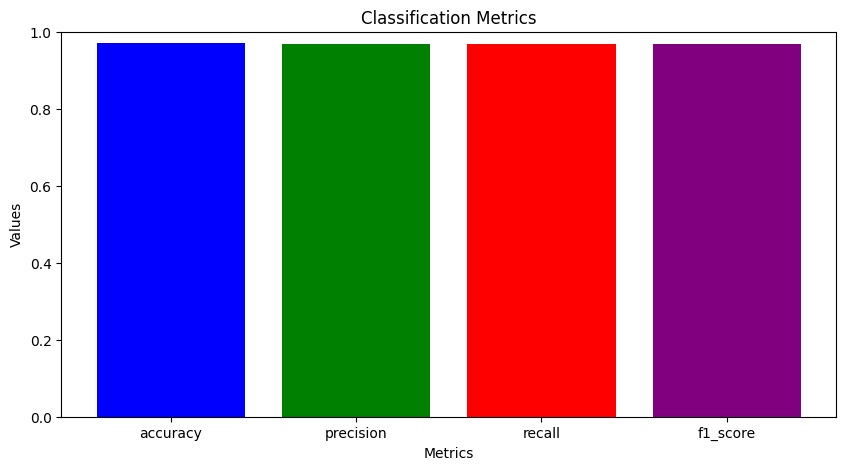

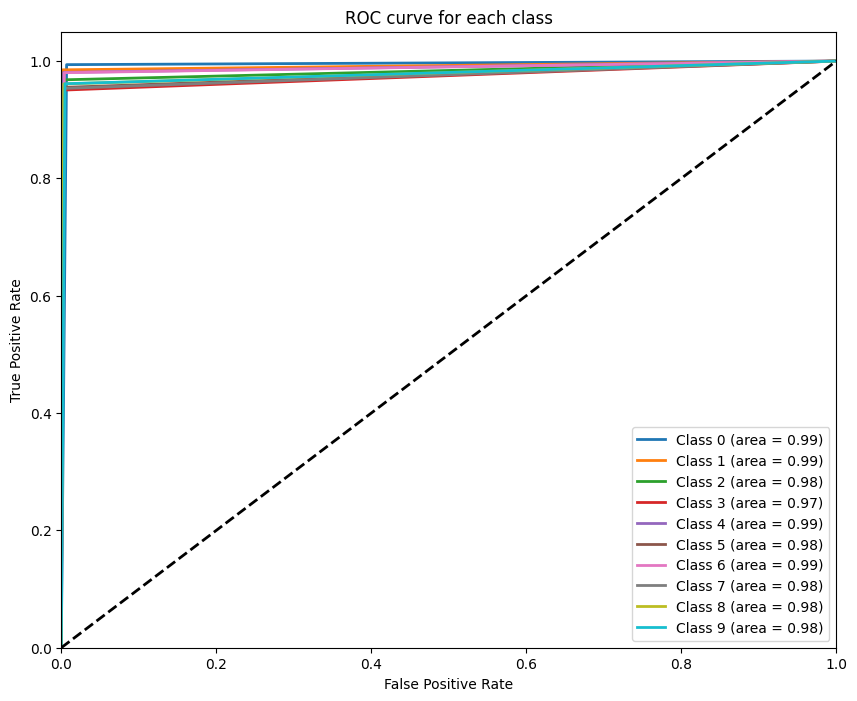

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Данные
y_true = np.array(all_test_labels)  # Истинные значения
y_pred = np.array(all_test_preds)  # Предсказанные значения

def calculate_metrics(y_true, y_pred):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average='macro')
    metrics['recall'] = recall_score(y_true, y_pred, average='macro')
    metrics['f1_score'] = f1_score(y_true, y_pred, average='macro')
    return metrics

def plot_metrics(metrics):
    labels = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=['blue', 'green', 'red', 'purple'])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Classification Metrics')
    plt.show()

def plot_roc_auc(y_true, y_pred, num_classes):
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for each class')
    plt.legend(loc="lower right")
    plt.show()

metrics = calculate_metrics(y_true, y_pred)
print(metrics)
plot_metrics(metrics)
num_classes = 10  # Для MNIST
plot_roc_auc(y_true, y_pred, num_classes)
